In [1]:
from CIB import causal_information_bottleneck
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def plot_information_function_even(rate_values, distortion_values, E, C_mu):
    """
    Plot the information function (code rate vs. distortion) for the Even process.
    
    Parameters:
    rate_values: Array of rate values (I[R;σ+])
    distortion_values: Array of distortion values (I[σ+;σ-|R])
    E: Excess entropy (I[σ+;σ-])
    C_mu: Statistical complexity (H[σ+])
    """
    plt.figure(figsize=(10, 6))
    
    # Plot the given rate and distortion values
    plt.plot(distortion_values, rate_values, 'ro-', label='reproducing')
    
    # For the Even process, plot a straight line connecting (0,E) and (E,0)
    # where E = C_mu
    x_line = np.array([0, E])
    y_line = np.array([E, 0])
    plt.plot(x_line, y_line, 'b-', label='original')
    
    plt.axhline(y=C_mu, color='k', linestyle='-.', label=r'$C_\mu$')
    plt.axvline(x=0, color='k', linestyle='-')
    plt.axvline(x=E, color='k', linestyle=':', label=r'$E$')
    plt.xlabel(r'$I[\overset{\leftarrow}{X};\overset{\rightarrow}{X}|R]$')
    plt.ylabel(r'$I[R;\overset{\leftarrow}{X}]$')
    plt.title('Information Function for Even Process')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # Highlight x=0 and y=0 axes in solid black lines
    plt.axhline(y=0, color='black')
    plt.axvline(x=0, color='black')
    
    plt.tight_layout()
    plt.show()
    
def plot_feature_curve_even(feature_curve, C_mu):
    """
    Plot the feature curve (rate vs. beta) for the Even process.
    
    Parameters:
    feature_curve: Array of (beta, rate) pairs
    C_mu: Statistical complexity (H[σ+])
    """
    # Extract data from feature_curve
    betas = feature_curve[:, 0]
    rates = feature_curve[:, 1]
    
    plt.figure(figsize=(10, 6))
    
    # Plot feature_curve data with lines
    plt.plot(betas, rates, 'ro-', label='reproducing')
    
    # Use step function to represent the original Even process feature curve
    beta_step = np.array([0, 1, 1, 14])
    rate_step = np.array([0, 0, C_mu, C_mu])
    plt.plot(beta_step, rate_step, 'b-', label='original')
    
    # Plot C_mu line
    plt.axhline(y=C_mu, color='k', linestyle='--', label=r'$C_\mu$')
    
    # Set axis labels
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$I[R;\overset{\leftarrow}{X}]$')
    
    # Add finer granularity in x-axis ticks
    max_beta = max(betas.max(), 14)  # Use the larger of the data max or 14
    plt.xticks(np.arange(0, max_beta + 1, 0.5))  # Ticks every 0.5 units
    
    plt.title('Feature Curve for Even Process')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Highlight x=0 and y=0 axes in solid black lines
    plt.axhline(y=0, color='black')
    plt.axvline(x=0, color='black')
    
    plt.tight_layout()
    plt.show()

def run_even_process_cib_analysis(num_clusters, beta_values,enforce_monotonicity=True, default_restarts=500, default_iter=300, max_restarts=5000, max_iter=500,annealing=False,perturbation_size=0.1):
    """
    Run the CIB analysis on the Even process and plot the results.
    
    Parameters:
    num_clusters (int): Number of clusters to use in the representation
    beta_values: Array of beta values to compute
    enforce_monotonicity: Whether to enforce monotonicity of the information function
    """
    # For the Even process:
    # - Forward probability p(sigma+) = (2/3, 1/3)
    # - Conditional probability p(sigma-|sigma+) = identity matrix (2x2)
    
    # Define the distributions
    p_sigma_plus = np.array([2/3, 1/3])  # Forward probability
    
    # Since p(sigma-|sigma+) is the identity matrix, the joint probability is:
    # p(sigma+, sigma-) = p(sigma+) * p(sigma-|sigma+) = p(sigma+) * I
    joint_prob = np.zeros((2, 2))
    joint_prob[0, 0] = p_sigma_plus[0]  # p(sigma+=0, sigma-=0) = p(sigma+=0)
    joint_prob[1, 1] = p_sigma_plus[1]  # p(sigma+=1, sigma-=1) = p(sigma+=1)
    
    # Calculate reverse-time marginal probability
    p_sigma_minus = np.sum(joint_prob, axis=0)
    
    # Verify that distributions are normalized
    total_joint = np.sum(joint_prob)
    total_sigma_plus = np.sum(p_sigma_plus)
    
    print(f"Joint distribution sum: {total_joint:.10f} (should be close to 1.0)")
    print(f"Forward state distribution sum: {total_sigma_plus:.10f} (should be close to 1.0)")
    
    # Calculate excess entropy (mutual information between σ+ and σ-)
    E = 0
    for i in range(2):
        for j in range(2):
            if joint_prob[i,j] > 0:
                # Using log base 2 for information theory quantities in bits
                ratio = joint_prob[i,j] / (p_sigma_plus[i] * p_sigma_minus[j])
                E += joint_prob[i,j] * np.log2(ratio)
    
    # Add a sanity check
    if E < 0:
        print(f"WARNING: Calculated excess entropy is negative ({E:.6f}), which should not happen.")
        print("Checking for potential numerical issues...")
        
        # Check for numerical issues in the calculation
        min_ratio = float('inf')
        max_ratio = float('-inf')
        for i in range(2):
            for j in range(2):
                if joint_prob[i,j] > 0:
                    ratio = joint_prob[i,j] / (p_sigma_plus[i] * p_sigma_minus[j])
                    min_ratio = min(min_ratio, ratio)
                    max_ratio = max(max_ratio, ratio)
        
        print(f"Minimum ratio: {min_ratio:.10f}")
        print(f"Maximum ratio: {max_ratio:.10f}")
        
        # Try a more numerically stable calculation
        E_stable = 0
        for i in range(2):
            for j in range(2):
                if joint_prob[i,j] > 0:
                    # Avoid potential underflow/overflow in the ratio
                    log_joint = np.log2(max(joint_prob[i,j], 1e-100))
                    log_plus = np.log2(max(p_sigma_plus[i], 1e-100))
                    log_minus = np.log2(max(p_sigma_minus[j], 1e-100))
                    E_stable += joint_prob[i,j] * (log_joint - log_plus - log_minus)
        
        print(f"Recalculated excess entropy with more numerical stability: {E_stable:.6f} bits")
        #E = max(0, E_stable)  # Ensure non-negative result
    
    # Calculate statistical complexity
    C_mu = -np.sum(p_sigma_plus * np.log2(p_sigma_plus + (p_sigma_plus == 0)))
    
    print(f"Excess Entropy E = {E:.6f} bits")
    print(f"Statistical Complexity C_μ = {C_mu:.6f} bits")
    
    # Run CIB algorithm
    print("Running Causal Information Bottleneck algorithm...")
    rate_values, distortion_values, feature_curve = causal_information_bottleneck(
        joint_prob, p_sigma_plus, beta_values, num_clusters, 
        default_restarts=default_restarts, default_iter=default_iter,
        max_restarts=max_restarts, max_iter=max_iter,
        enforce_monotonicity=enforce_monotonicity,
        convergence_threshold=1e-6,
        annealing=annealing,
        perturbation_size=perturbation_size
    )
    
    # Sort results by distortion (for smooth curves)
    idx = np.argsort(distortion_values)
    rate_values = rate_values[idx]
    distortion_values = distortion_values[idx]
    
    # Plot results
    plot_information_function_even(rate_values, distortion_values, E, C_mu)
    plot_feature_curve_even(feature_curve, C_mu)
    
    return rate_values, distortion_values, feature_curve, E, C_mu

Analyzing the Even process
Using 2 clusters for the analysis
Joint distribution sum: 1.0000000000 (should be close to 1.0)
Forward state distribution sum: 1.0000000000 (should be close to 1.0)
Excess Entropy E = 0.918296 bits
Statistical Complexity C_μ = 0.918296 bits
Running Causal Information Bottleneck algorithm...
M in conditional_probability_minus_given_plus 1
Total mutual information I[σ+;σ-] = 0.918296 bits
###########################################################
[0.0%] Processing β=0.100000
best_objective 0.0 best_distortion 0.9182958340544893 best_rate 0.0
H[σ+] 0.9182958340544896 H[σ+|R] 0.9182958340544896
###########################################################
[3.7%] Processing β=0.550000
best_objective -1.4906350904757036e-17 best_distortion 0.9182958340544893 best_rate 1.8218873328036375e-17
H[σ+] 0.9182958340544896 H[σ+|R] 0.9182958340544897
###########################################################
[7.4%] Processing β=0.600000
best_objective 4.6378936602539654e-1

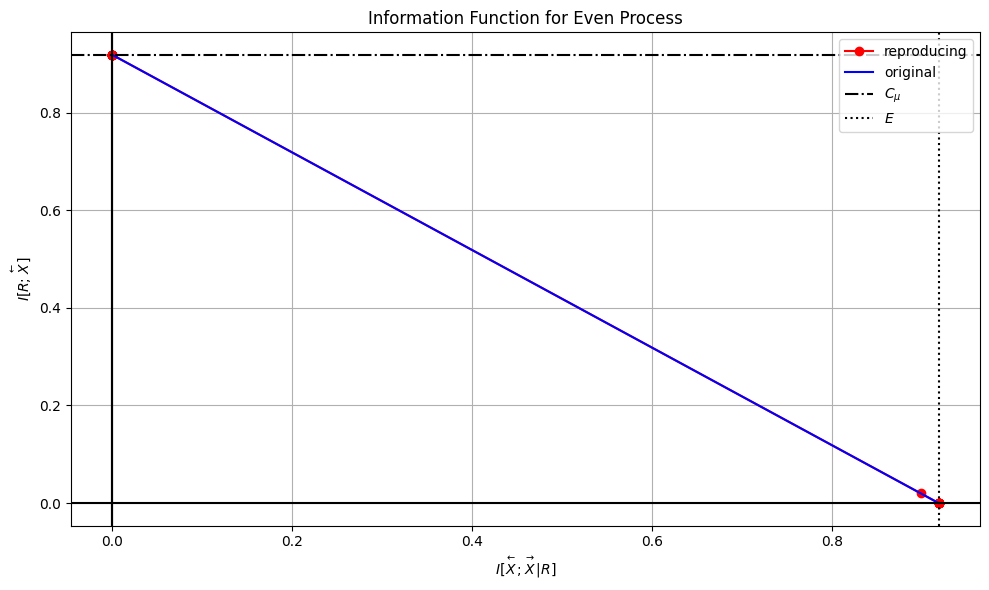

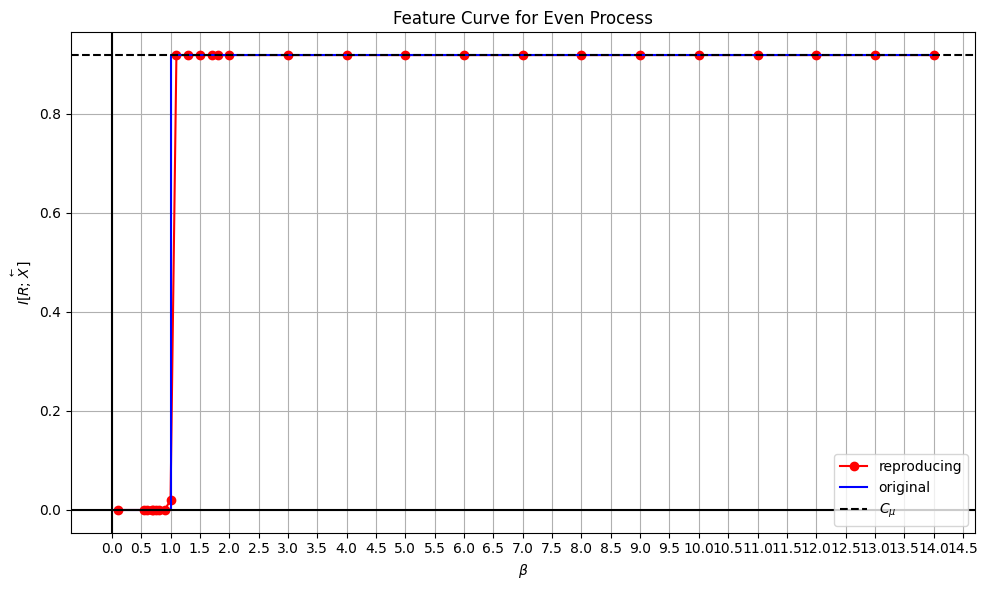

In [3]:
if __name__ == "__main__":
    # Set parameters for the Even process
    num_clusters_even = 2
    beta_even = np.array([0.1,0.55,0.6,0.69,0.7,0.75,0.8,0.9,1.,1.1,1.3,1.5,1.7,1.8,  2.,  3.,  4.,  5.,  6.,  7., 8, 9,10,11,12,13 ,14.])
    print(f"Analyzing the Even process")
    print(f"Using {num_clusters_even} clusters for the analysis")
    
    # Run the analysis
    results_even = run_even_process_cib_analysis(num_clusters=num_clusters_even,beta_values=beta_even,default_restarts=10, default_iter=300, max_restarts=5000, max_iter=500,enforce_monotonicity=False,annealing=True,perturbation_size=0.1)